# Modelling Experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
cwd = os.getcwd()
print(cwd)

c:\Users\danie\Documents\GitHub\pandemic_modelling\modelling


In [3]:
df = pd.read_csv('../Data/gold/covid_daily_multivariate_weekly.csv')
df.head()

,country,date,new_cases,cumulative_cases,co,no2,o3,pm10,pm25,so2,...,open defe,people using at least,people using safely managed,population ages,population ages 15,population ages 65,population density people,prevalence of,rural population,population
0,Chile,2020-03-29,1558,2245,40.800000,36.700000,74.333333,198.454545,265.666667,26.416667,...,0.0,100.0,98.771371,18.412814,68.96037,12.626816,26.052173,0.6,2377357.0,19331414.0
1,Chile,2020-04-05,2420,4665,41.850000,45.616667,96.400000,272.454545,355.083333,28.250000,...,0.0,100.0,98.771371,18.412814,68.96037,12.626816,26.052173,0.6,2377357.0,19331414.0
2,Chile,2020-04-12,2987,7652,43.650000,48.950000,89.133333,302.000000,462.500000,26.883333,...,0.0,100.0,98.771371,18.412814,68.96037,12.626816,26.052173,0.6,2377357.0,19331414.0
3,Chile,2020-04-19,3304,10956,51.683333,61.400000,81.950000,302.636364,483.416667,28.533333,...,0.0,100.0,98.771371,18.412814,68.96037,12.626816,26.052173,0.6,2377357.0,19331414.0
4,Chile,2020-04-26,4054,15010,47.200000,47.516667,82.383333,270.636364,443.250000,25.633333,...,0.0,100.0,98.771371,18.412814,68.96037,12.626816,26.052173,0.6,2377357.0,19331414.0


# Wrangle

In [4]:
df['cases_t_4'] = df.groupby('country')['new_cases'].shift(-4)

In [7]:
df['cases_lag1'] = df.groupby('country')['cumulative_cases'].shift(1)

In [8]:
print(df['cases_t_4'].isnull().sum(), 'Nans for cases_t_4')
print(df['cases_lag1'].isnull().sum(), 'Nans for cases_lag1')

16 Nans for cases_t_4
4 Nans for cases_lag1


In [9]:
# drop if cases_t_4 is null
df = df.dropna(subset=['cases_t_4'])
df = df.dropna(subset=['cases_lag1'])

In [10]:
# convert date to numeric
df['date'] = pd.to_datetime(df['date'])
df['date_numeric'] = df['date'].apply(lambda x: x.timestamp())

In [11]:
df_og = df.copy()

In [12]:
# dummies for countries
df = pd.get_dummies(df, columns=['country'], drop_first=True)

# Regression Framework

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def plot_country_residuals_scaled(df, model):
    countries = df['country'].unique()
    n_countries = len(countries)

    fig, axes = plt.subplots(nrows=2, ncols=(n_countries + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, country in enumerate(countries):
        # Filter data for the current country
        df_country = df[df['country'] == country]

        # Define explanatory and target variables
        X = df_country.drop(columns=['new_cases', 'cases_t_4', 'date', 'country'])
        y = df_country['new_cases']

        # Split data (80/20 split, time-series style)
        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        dates_test = df_country['date'].iloc[split_idx:]

        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit provided model on scaled data
        model.fit(X_train_scaled, y_train)

        # Predict and compute residuals
        y_pred = model.predict(X_test_scaled)
        residuals = y_test - y_pred

        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)

        # Plot residuals
        ax = axes[idx]
        ax.plot(dates_test, residuals, marker='o', linestyle='-', markersize=3)
        ax.axhline(y=0, color='red', linestyle='--')
        ax.set_title(f"{country} Residuals (MSE: {mse:.2f})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Residual")
        ax.tick_params(axis='x', rotation=45)

    # Remove any empty subplots
    for idx in range(n_countries, len(axes)):
        fig.delaxes(axes[idx])

    fig.tight_layout()
    plt.show()

# Example usage:
# from sklearn.linear_model import Lasso
# plot_country_residuals(df_og, Lasso(alpha=1.0))


# OLS

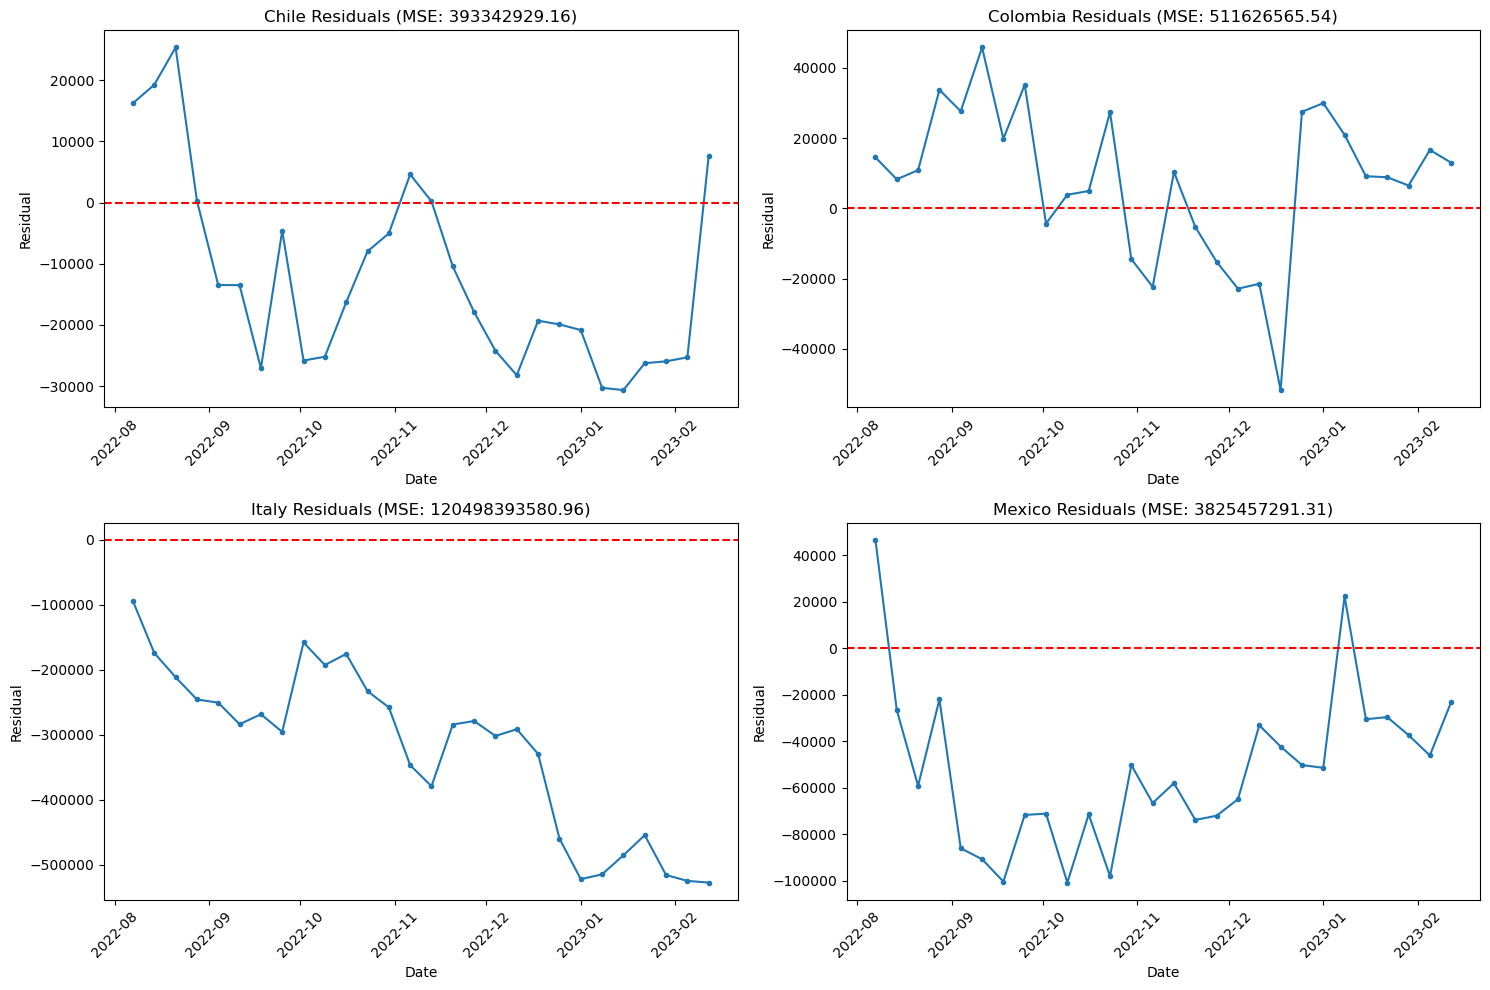

In [14]:
from sklearn.linear_model import LinearRegression
plot_country_residuals_scaled(df_og, LinearRegression())

## Lasso

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.437e+10, tolerance: 2.658e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.555e+09, tolerance: 2.633e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

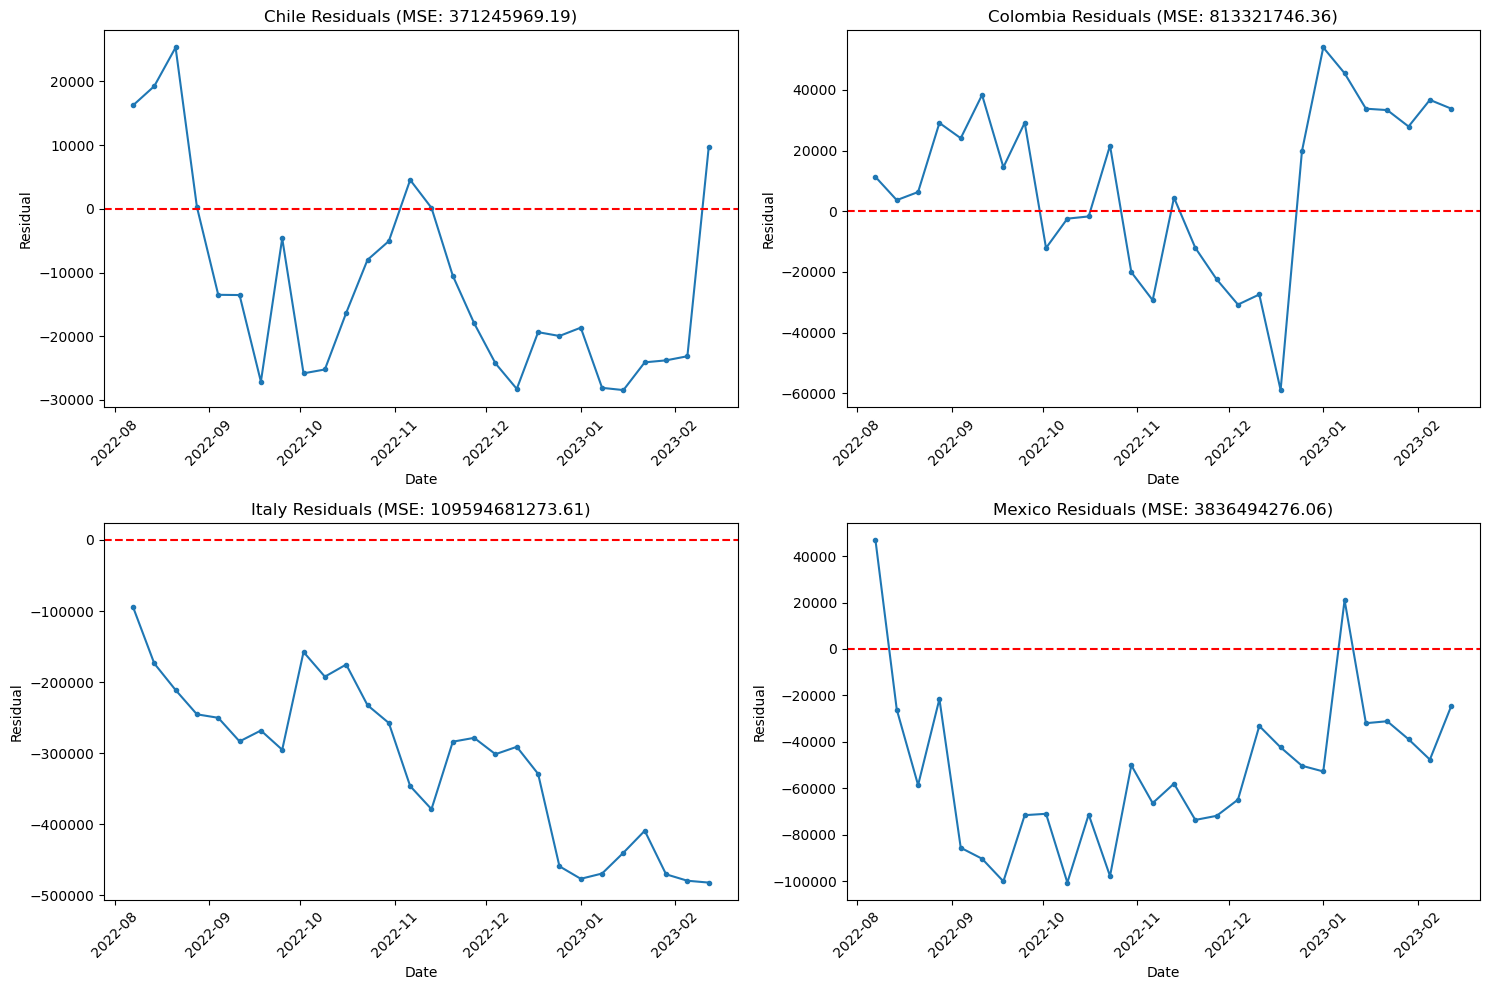

In [15]:
from sklearn.linear_model import Lasso
plot_country_residuals_scaled(df_og, Lasso(alpha=1.0))

## Ridge

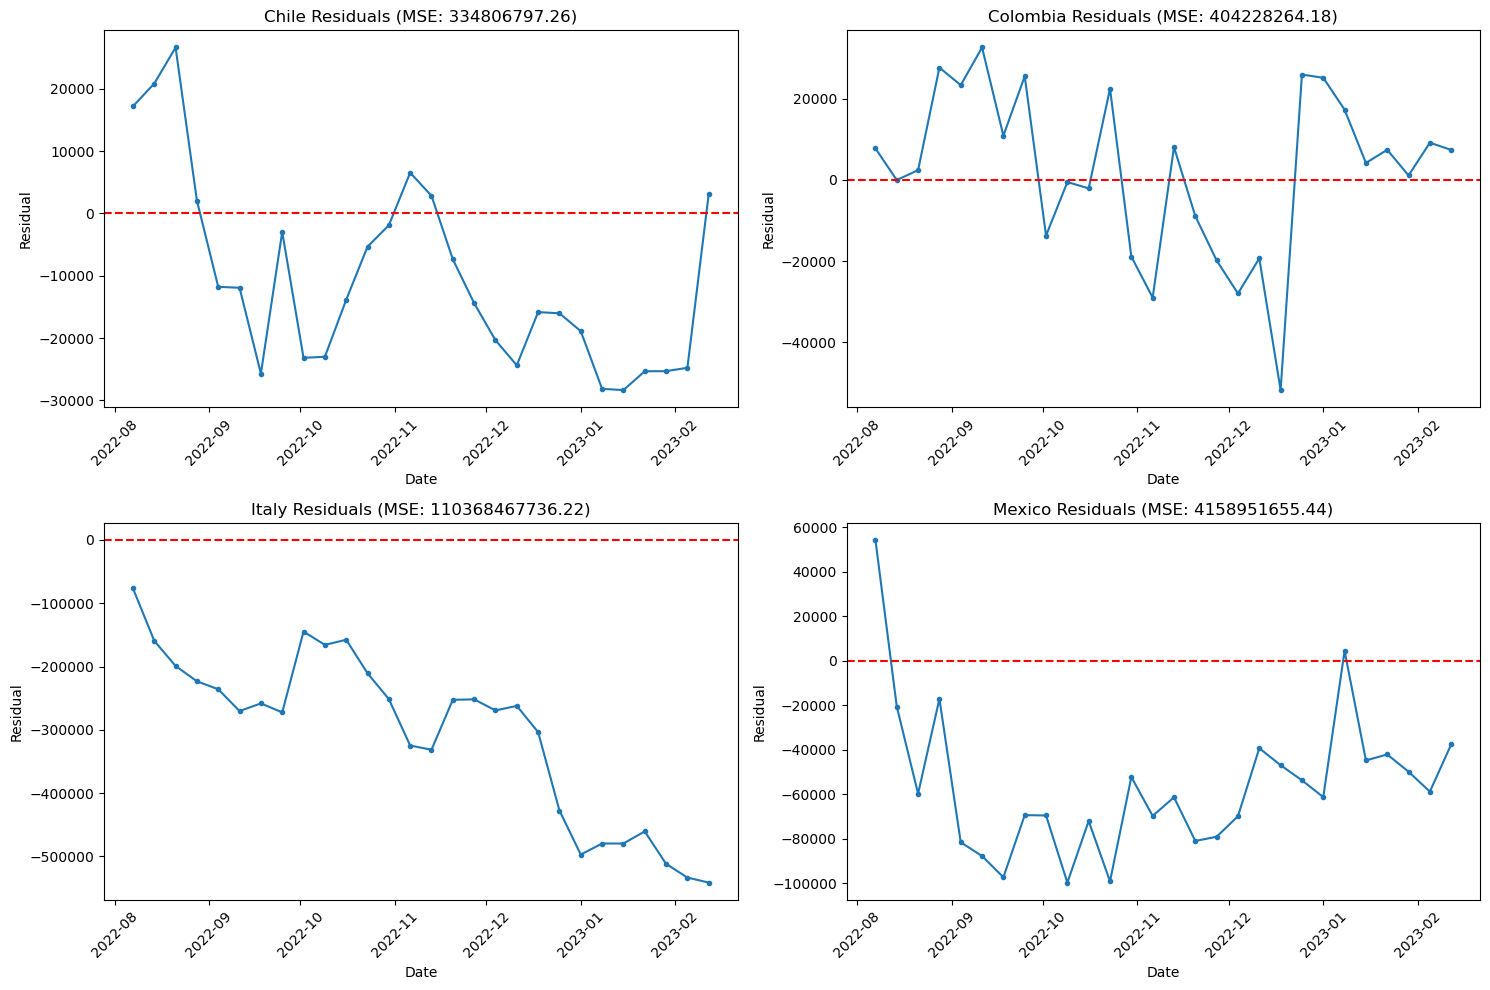

In [16]:
from sklearn.linear_model import Ridge
plot_country_residuals_scaled(df_og, Ridge(alpha=1.0))

## Elastic Net

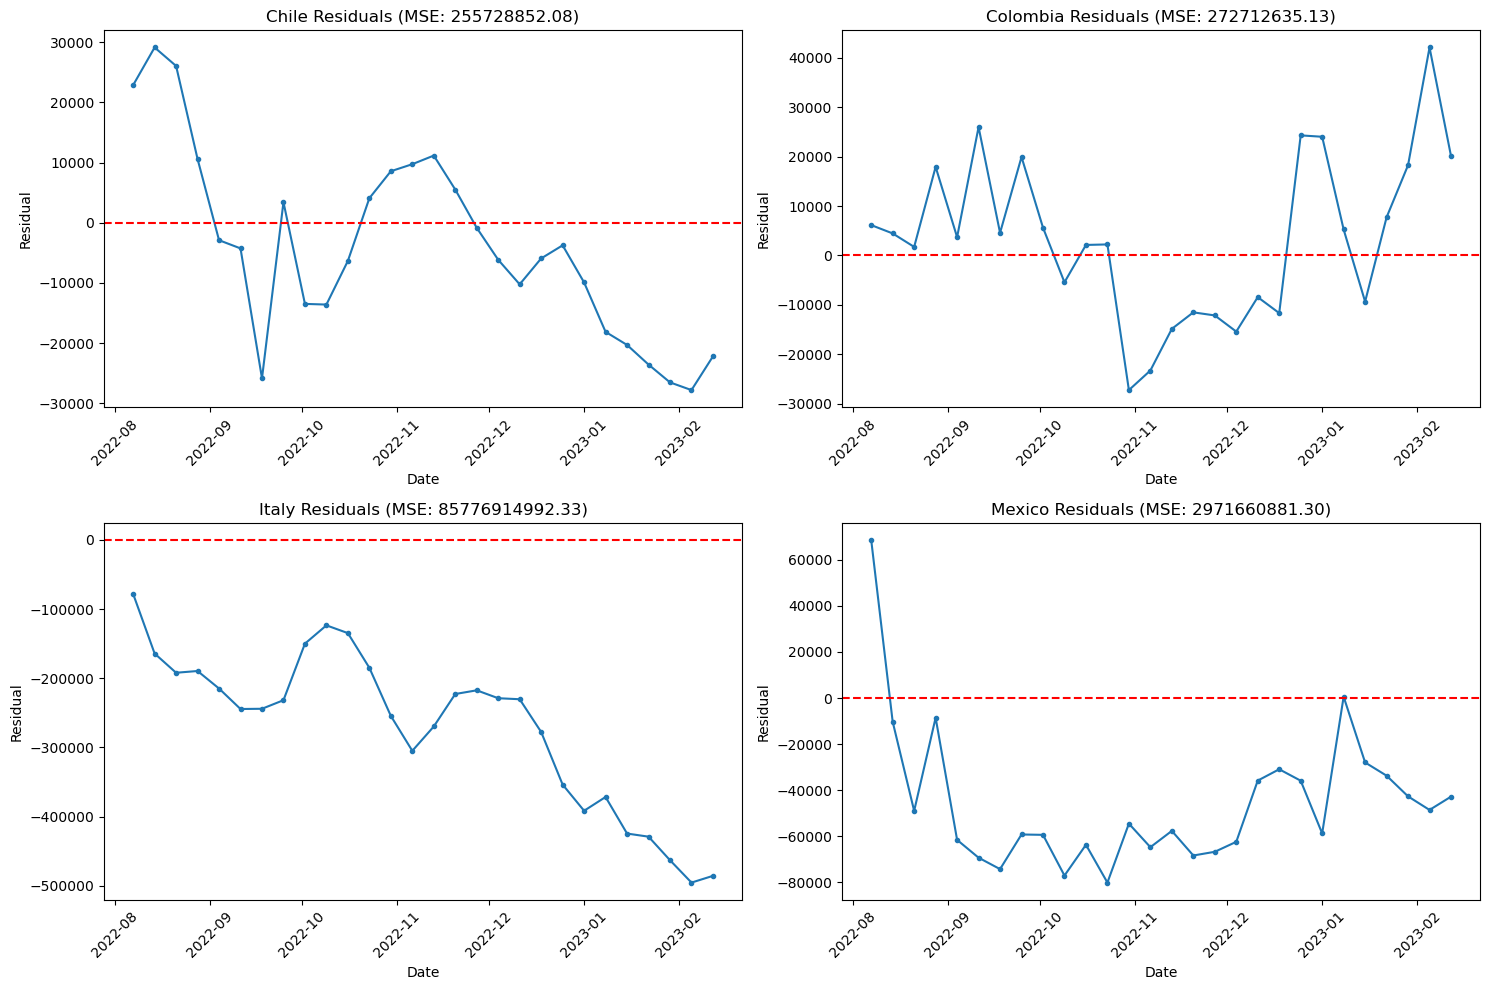

In [17]:
from sklearn.linear_model import ElasticNet
plot_country_residuals_scaled(df_og, ElasticNet(alpha=1.0, l1_ratio=0.5))

## Random Forest

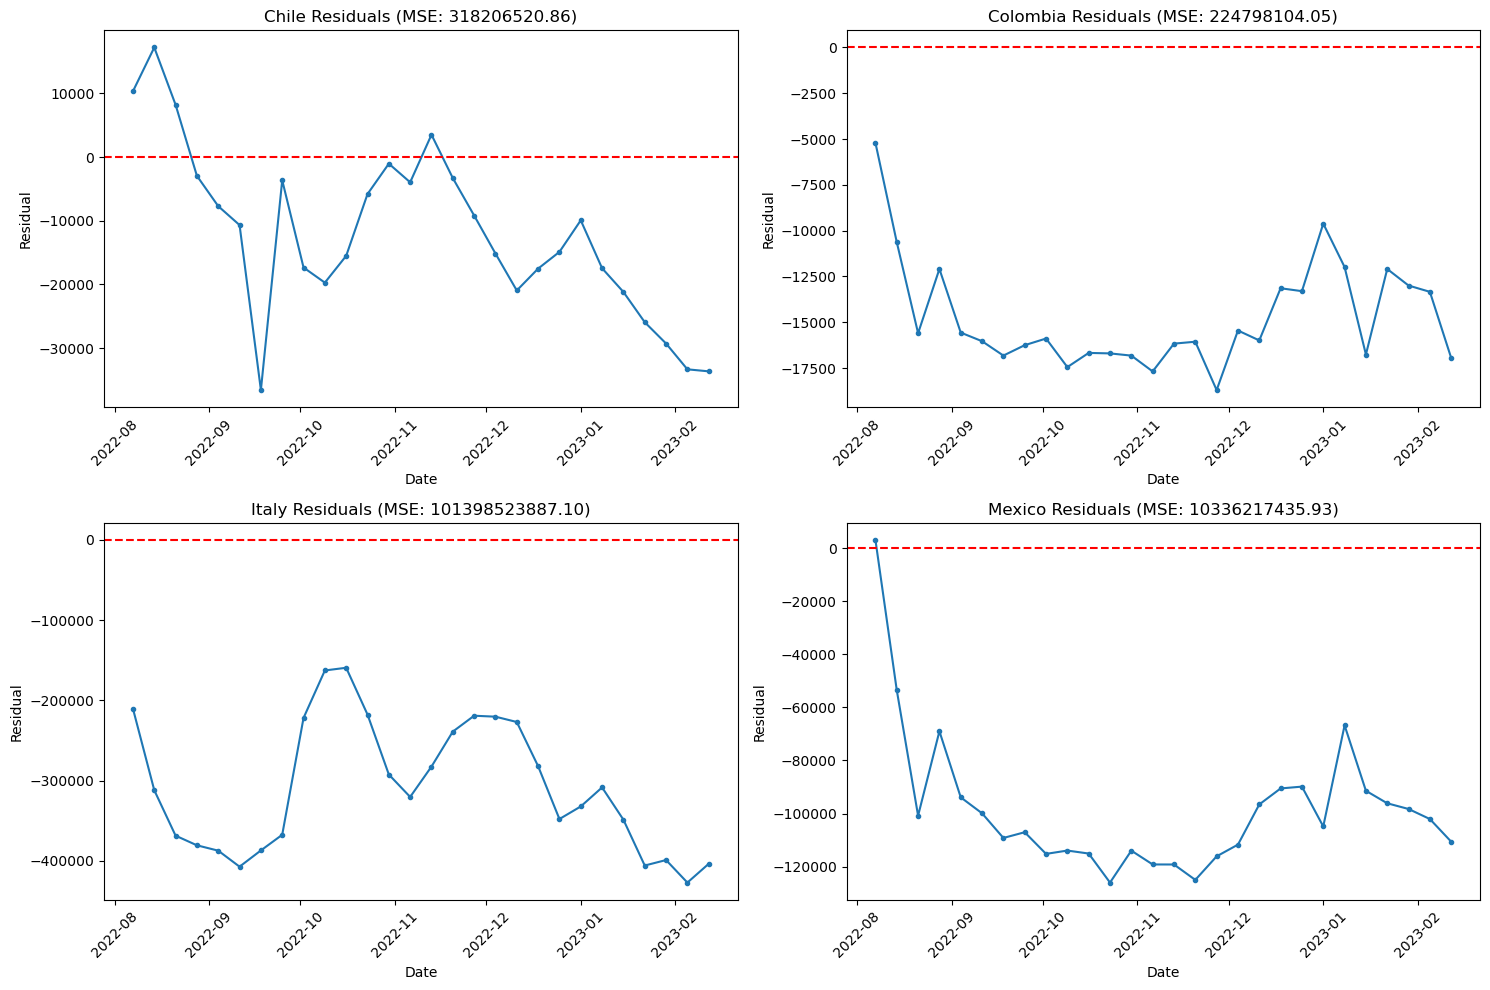

In [18]:
from sklearn.ensemble import RandomForestRegressor
plot_country_residuals_scaled(df_og, RandomForestRegressor())

## Gradient Boosting

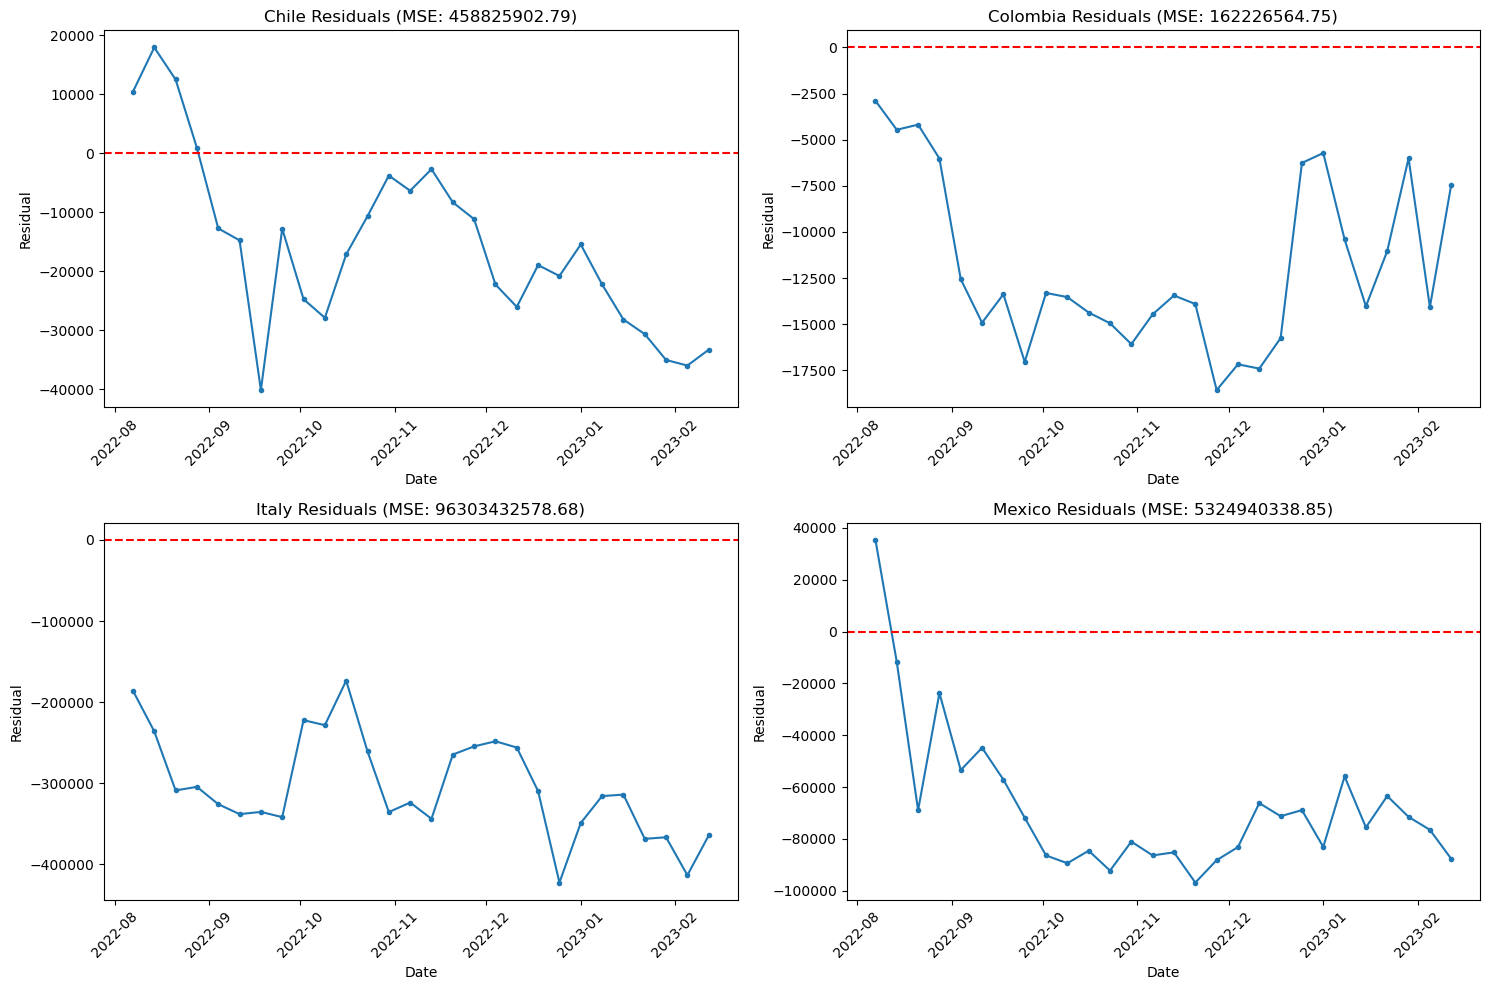

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
plot_country_residuals_scaled(df_og, GradientBoostingRegressor())

## Metrics

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd

def evaluate_models_per_country(df):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    countries = df['country'].unique()
    all_results = []

    for country in countries:
        df_country = df[df['country'] == country]

        X = df_country.drop(columns=['new_cases' ,'cumulative_cases' , 'cases_t_4', 'date', 'country'])
        y = df_country['new_cases']

        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Standard Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            all_results.append({
                'country': country,
                'model': model_name,
                'RMSE': rmse,
                'R2': r2
            })

    return pd.DataFrame(all_results)

In [21]:
# Example usage:
results_df = evaluate_models_per_country(df_og)
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.511e+09, tolerance: 2.658e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.667e+10, tolerance: 2.633e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

     country             model           RMSE         R2
0      Chile  LinearRegression   15733.167701   0.062848
1      Chile             Lasso   15136.768339   0.132551
2      Chile             Ridge   15819.622479   0.052520
3      Chile        ElasticNet   15864.376413   0.047152
4      Chile      RandomForest   15230.567346   0.121767
5      Chile  GradientBoosting   22321.605936  -0.886378
6   Colombia  LinearRegression   25132.878766 -61.089804
7   Colombia             Lasso   28473.428022 -78.692110
8   Colombia             Ridge   20070.483723 -38.596016
9   Colombia        ElasticNet   16675.104293 -26.332096
10  Colombia      RandomForest   14981.754207 -21.062826
11  Colombia  GradientBoosting   12905.408387 -15.371155
12     Italy  LinearRegression  305648.499683 -16.524650
13     Italy             Lasso  283961.941343 -14.126034
14     Italy             Ridge  314196.387312 -17.518559
15     Italy        ElasticNet  276572.445086 -13.349033
16     Italy      RandomForest 

In [22]:
# Group by model and calculate the mean RMSE for each model
mean_rmse_per_model = results_df.groupby('model')['RMSE'].mean()

# Find the model with the lowest mean RMSE
best_model = mean_rmse_per_model.idxmin()
lowest_mean_rmse = mean_rmse_per_model.min()

print(f"The model with the lowest mean RMSE is {best_model} with a mean RMSE of {lowest_mean_rmse:.2f}")

The model with the lowest mean RMSE is ElasticNet with a mean RMSE of 90789.70


In [23]:
mean_rmse_per_model

model
ElasticNet           90789.695137
GradientBoosting    101910.936733
Lasso                97977.656177
LinearRegression    102962.387756
RandomForest        103590.333870
Ridge               103708.836944
Name: RMSE, dtype: float64

In [24]:
results_df[results_df['model'] == 'ElasticNet']

,country,model,RMSE,R2
3,Chile,ElasticNet,15864.376413,0.047152
9,Colombia,ElasticNet,16675.104293,-26.332096
15,Italy,ElasticNet,276572.445086,-13.349033
21,Mexico,ElasticNet,54046.854755,-2.451849


## Cases t+4
4 weeks later

In [27]:
def evaluate_models_per_country_4(df):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    countries = df['country'].unique()
    all_results = []

    for country in countries:
        df_country = df[df['country'] == country]

        y = df_country['cases_t_4']
        X = df_country.drop(columns=['cases_t_4', 'date', 'country', 'cases_lag1'])

        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Standard Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            all_results.append({
                'country': country,
                'model': model_name,
                'RMSE': rmse,
                'R2': r2
            })

    return pd.DataFrame(all_results)


In [28]:

results_df_4 = evaluate_models_per_country_4(df_og)
print(results_df_4)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e+09, tolerance: 2.633e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.986e+10, tolerance: 2.626e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

     country             model           RMSE           R2
0      Chile  LinearRegression   32911.962096    -8.243554
1      Chile             Lasso   32704.417910    -8.127341
2      Chile             Ridge   28148.627224    -5.761544
3      Chile        ElasticNet   25553.195576    -4.572138
4      Chile      RandomForest   36928.935930   -10.637643
5      Chile  GradientBoosting   38256.267095   -11.489257
6   Colombia  LinearRegression  102104.818707 -2183.654513
7   Colombia             Lasso  105569.645937 -2334.438413
8   Colombia             Ridge   40695.047534  -346.035105
9   Colombia        ElasticNet    8388.911749   -13.746927
10  Colombia      RandomForest    8168.289917   -12.981462
11  Colombia  GradientBoosting    8104.486494   -12.763893
12     Italy  LinearRegression  328515.979687   -14.360879
13     Italy             Lasso  319775.602427   -13.554381
14     Italy             Ridge  340874.949464   -15.538391
15     Italy        ElasticNet  263122.948575    -8.8541

In [29]:
# Group by model and calculate the mean RMSE for each model
mean_rmse_per_model_4 = results_df_4.groupby('model')['RMSE'].mean()

# Find the model with the lowest mean RMSE
best_model_4 = mean_rmse_per_model_4.idxmin()
lowest_mean_rmse_4 = mean_rmse_per_model_4.min()

print(f"The model with the lowest mean RMSE is {best_model_4} with a mean RMSE of {lowest_mean_rmse_4:.2f}")

The model with the lowest mean RMSE is ElasticNet with a mean RMSE of 87458.31


In [30]:
mean_rmse_per_model_4

model
ElasticNet           87458.312465
GradientBoosting    113161.083747
Lasso               131152.485856
LinearRegression    134703.244324
RandomForest        108884.323795
Ridge               119051.195451
Name: RMSE, dtype: float64

In [31]:
results_df_4[results_df_4['model'] == 'ElasticNet']

,country,model,RMSE,R2
3,Chile,ElasticNet,25553.195576,-4.572138
9,Colombia,ElasticNet,8388.911749,-13.746927
15,Italy,ElasticNet,263122.948575,-8.854181
21,Mexico,ElasticNet,52768.193961,-19.452949


# Explanatory variables

We now implement a version which compares all the countries in a single model so it can consider differences in variables such as population density

In [32]:
def evaluate_models(df, target_variable):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    if target_variable == 'new_cases':
        X = df.drop(columns=[target_variable, 'date', 'cumulative_cases', 'cases_lag1','cases_t_4'])
    elif target_variable == 'cases_t_4':
        X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])

    y = df[target_variable]

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Identify dummy (binary) columns
    dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
    numeric_cols = [col for col in X.columns if col not in dummy_cols]

    # Scale only numeric columns
    scaler = StandardScaler()
    X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

    # Reassemble scaled numeric columns and dummy columns
    X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

    all_results = []

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results_dict = {
            'Model': model_name,
            'RMSE': rmse,
            'R2': r2
        }

        all_results.append(results_dict)

    results_df = pd.DataFrame(all_results)
    return results_df


In [43]:
# call the function
results_df = evaluate_models(df, target_variable='new_cases')
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.854e+11, tolerance: 4.035e+08
  model = cd_fast.enet_coordinate_descent(


              Model          RMSE           R2
0  LinearRegression  1.393258e+06 -1202.748324
1             Lasso  1.147131e+05    -7.160163
2             Ridge  7.932725e+04    -2.902269
3        ElasticNet  4.603596e+04    -0.314216
4      RandomForest  4.726646e+04    -0.385411
5  GradientBoosting  4.471107e+04    -0.239660


In [33]:
# call the function
results_df = evaluate_models(df, target_variable='cases_t_4')
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.457e+11, tolerance: 4.020e+08
  model = cd_fast.enet_coordinate_descent(


              Model          RMSE           R2
0  LinearRegression  1.903569e+06 -2220.008832
1             Lasso  7.690960e+04    -2.625554
2             Ridge  9.652487e+04    -4.710732
3        ElasticNet  4.198064e+04    -0.080218
4      RandomForest  1.198824e+05    -7.808943
5  GradientBoosting  1.017309e+05    -5.343361


# Check Explainability

### Lasso

In [44]:
from sklearn.linear_model import LassoCV

# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cumulative_cases', 'cases_t_4'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (lambda): {best_alpha}")

# Predict on test set
y_pred = lasso_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[lasso_cv.coef_ != 0]
print(f"Selected features by Lasso: {list(selected_features)}")


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574008104.8527832, tolerance: 382547468.0819591
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1277344023.4699707, tolerance: 382547468.0819591
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1981963936.4987793, tolerance: 382547468.0819591
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\s

Best alpha (lambda): 285.8365369631136
RMSE: 44258.8764
R2: -0.2147
Selected features by Lasso: [np.str_('co'), np.str_('no2'), np.str_('pm10'), np.str_('pm25'), np.str_('so2'), np.str_('prcp'), np.str_('mean_distance_avg_14day_movavg'), np.str_('newly infected'), np.str_('individuals using the'), np.str_('life expectancy at'), np.str_('net migration'), np.str_('people using at least'), np.str_('rural population'), np.str_('date_numeric')]


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2440242092.817383, tolerance: 370297672.2059207
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9104655986.936035, tolerance: 370297672.2059207
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15347436787.397705, tolerance: 370297672.2059207
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sk

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1687663934.8894043, tolerance: 569918386.1461
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4121785920.923828, tolerance: 569918386.1461
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6522929808.017334, tolerance: 569918386.1461
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\lin

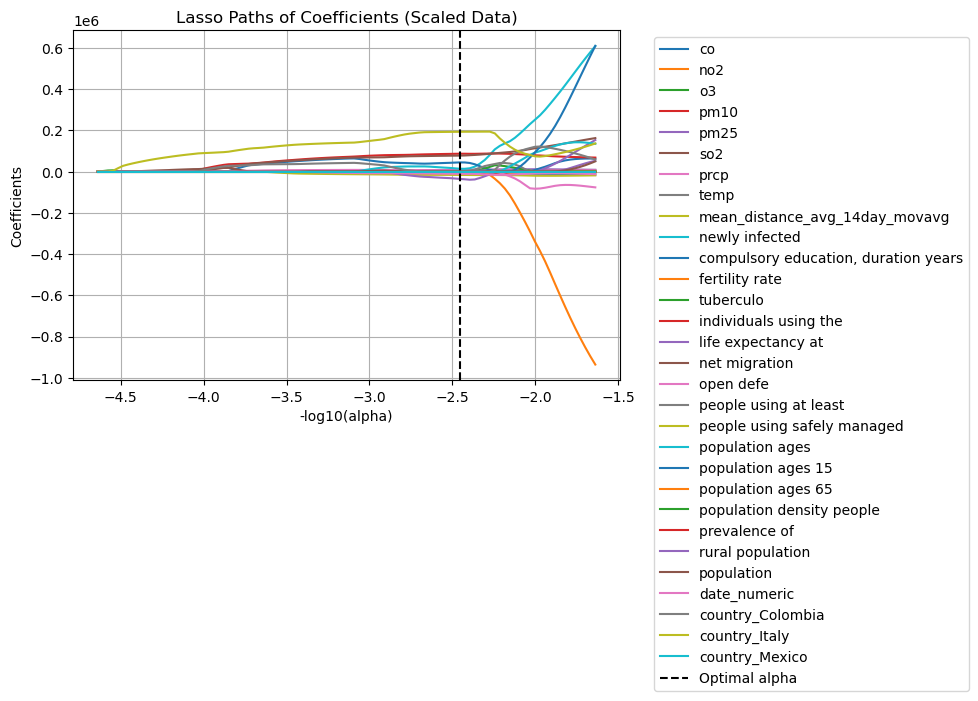

In [45]:
from sklearn.linear_model import lasso_path

# Compute coefficient paths using scaled data
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_lasso)

# Combine numeric and dummy feature names
feature_names = numeric_cols + dummy_cols

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_lasso, feature_names):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths of Coefficients (Scaled Data)')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (lambda): {best_alpha}")

# Predict on test set
y_pred = lasso_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[lasso_cv.coef_ != 0]
print(f"Selected features by Lasso: {list(selected_features)}")


In [ ]:
from sklearn.linear_model import lasso_path

# Compute coefficient paths using scaled data
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_lasso)

# Combine numeric and dummy feature names
feature_names = numeric_cols + dummy_cols

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_lasso, feature_names):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths of Coefficients (Scaled Data)')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

### Elastic Net

In [36]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda) and l1_ratio
elasticnet_cv = ElasticNetCV(cv=5, random_state=42, l1_ratio=[.1, .3,  .5, .7, .9, .95, .99, 1])

elasticnet_cv.fit(X_train_scaled, y_train)

# Best parameters
best_alpha = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_
print(f"Best alpha (lambda): {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Predict on test set
y_pred = elasticnet_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[elasticnet_cv.coef_ != 0]
print(f"Selected features by ElasticNet: {list(selected_features)}")


Best alpha (lambda): 5265.089552364166
Best l1_ratio: 1.0
RMSE: 39347.5060
R2: 0.0510
Selected features by ElasticNet: [np.str_('new_cases'), np.str_('cumulative_cases'), np.str_('co'), np.str_('no2'), np.str_('net migration'), np.str_('population ages 15')]


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699873907.5185547, tolerance: 381338367.76608646
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2654078961.366211, tolerance: 381338367.76608646
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1283597335.2434082, tolerance: 381338367.76608646
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages

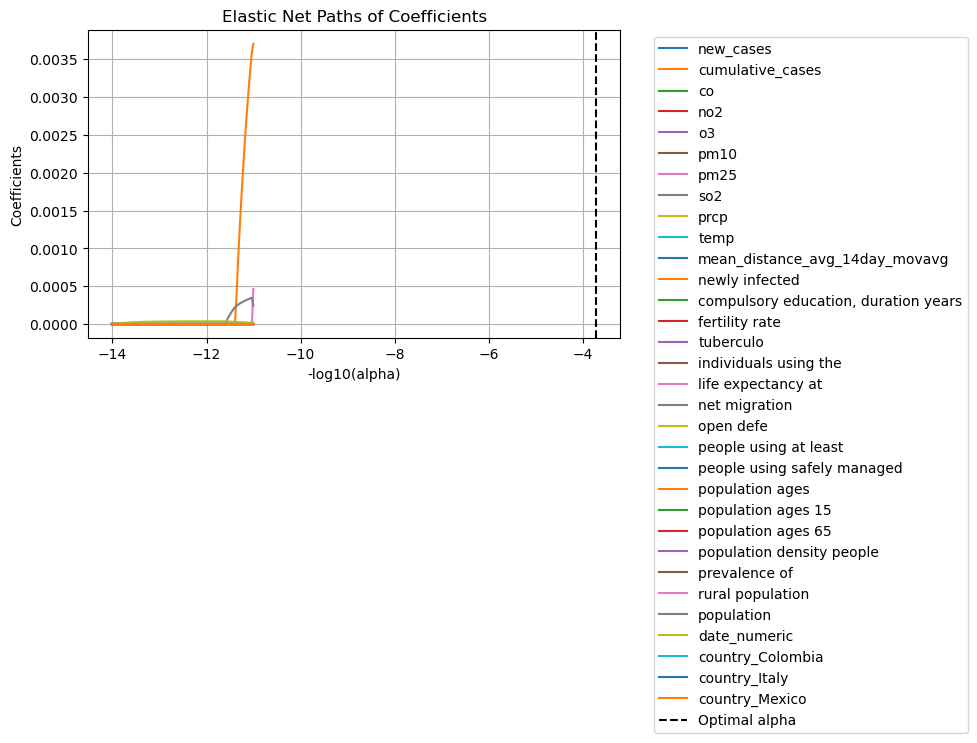

In [37]:
from sklearn.linear_model import enet_path
# Compute coefficient paths using enet_path
alphas_enet, coefs_enet, _ = enet_path(X_train, y_train, l1_ratio=best_l1_ratio)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_enet)

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_enet, X.columns):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Elastic Net Paths of Coefficients')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [38]:
print(best_alpha)


5265.089552364166


## Random Forest

In [46]:
from sklearn.model_selection import GridSearchCV

# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cumulative_cases', 'cases_t_4'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RMSE: 48513.3552
R2: -0.4595


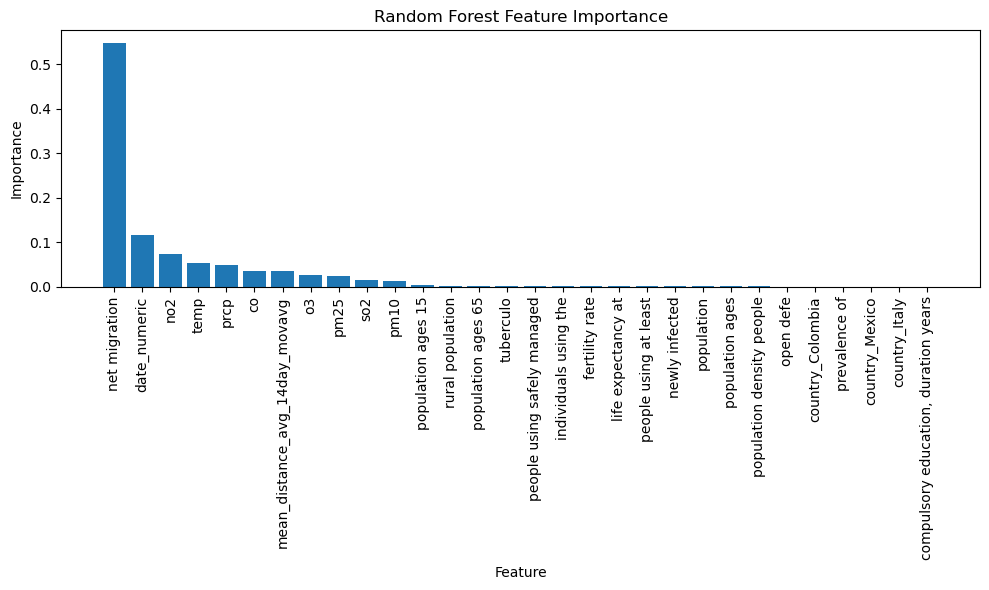

In [47]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [48]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
RMSE: 102754.7371
R2: -5.4717


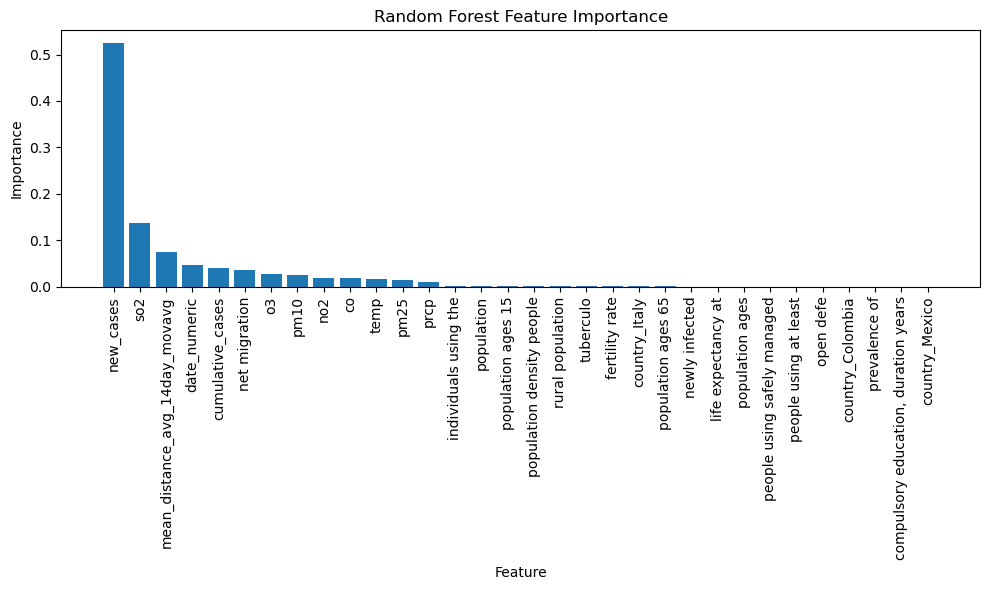

In [49]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

## Gradient Boosting

In [41]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Hyperparameter optimization via GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 95970.8556
R2: -4.6454


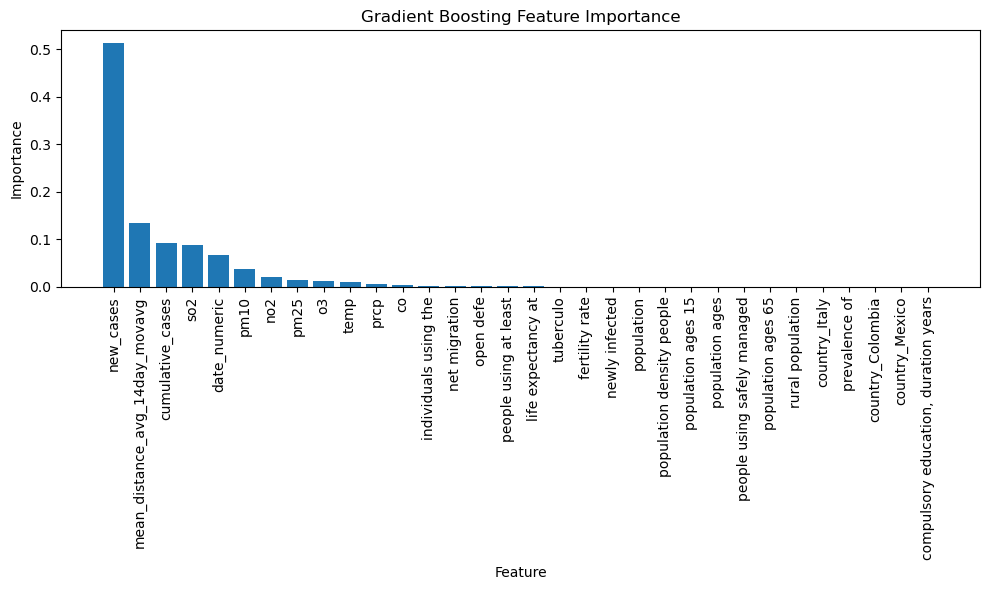

In [42]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Gradient Boosting Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [50]:
# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cumulative_cases', 'cases_t_4'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Hyperparameter optimization via GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
RMSE: 41371.8658
R2: -0.0614


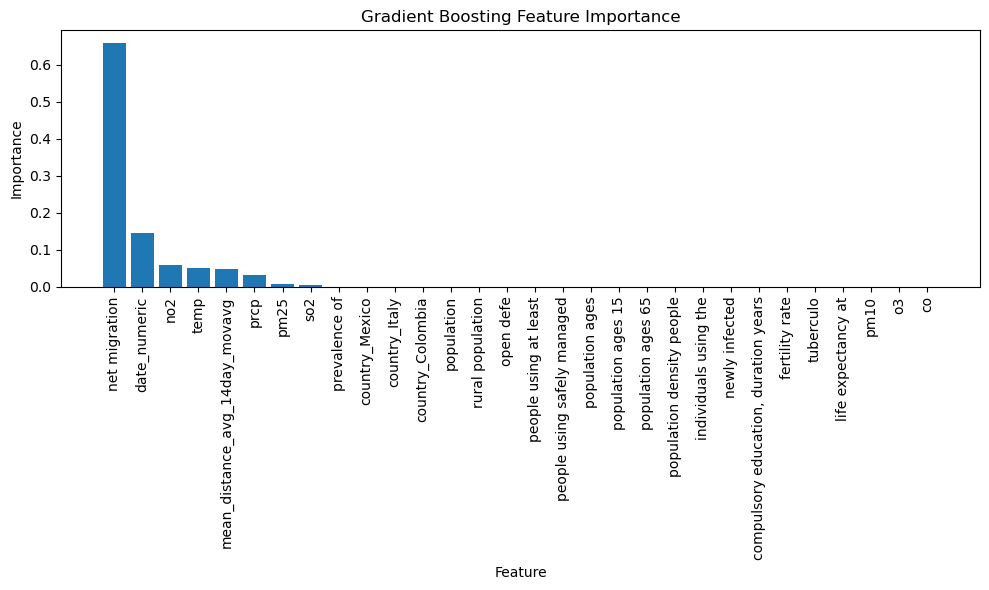

In [51]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Gradient Boosting Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [53]:
!pip install shap

   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   ---------------------------------------- 531.1/531.1 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------------------------------- ------ 2.4/2.8 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.6 MB 9.0 MB/s eta 0:00:02
   -------------- ------------------------- 4.5/12.6 MB 9.9 MB/s eta 0:00:01
   -------------------- ------------------- 6.6/12.6 MB 10.1 MB/s eta 0:00:01
   --------------------------- ------------ 8.7/12.6 MB 9.9 MB/s eta 0:00:01
   ---------------------------------- ----- 10.7/12.6 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------  12.3/12.6 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 9.5 MB/s eta 0:00:00
   ----------

  You can safely remove it manually.
  You can safely remove it manually.


In [55]:
import shap

# Initialize the SHAP explainer with the best estimator from the grid search
explainer = shap.Explainer(grid_search.best_estimator_, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.